# CMS28 Smart Pix NN

## Deep clean

In [1]:
## Library setup

Disable some console warnings

In [2]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Import libraries

In [3]:
# Standard library imports
import math

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pandas import read_csv
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

# TensorFlow imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, Lambda, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# QKeras imports
from qkeras import *

# Local imports
from hep_utils import plot_pt_filter, get_number_of_tracks, get_bkg_rej
from utils import *


# Magic commands
#%matplotlib inline

## Prepare dataset

### Load dataset

#### ds8

`dataset 8`

#### ds8q

`dataset 8` and the 14th column is distributed on the range `[0,11]`

#### ds8-local

`dataset 8` but split for _each local bin_

<p style="background-color:Yellow;"><b>Choose the local bin (y-local).</b></p>

In [4]:
local_id = 0 # 0 - 11

<p style="background-color:Yellow;"><b>Run identifier.</b></p>

In [5]:
run_id = 0

In [6]:
dataset = 'ds8l{}_'.format(local_id)

base_dir = 'data/ds8_only'

train_data = '{}/dec6_ds8_quant/QuantizedInputTrainSetLocal{}.csv'.format(base_dir, local_id)
train_label = '{}/dec6_ds8_quant/TrainSetLabelLocal{}.csv'.format(base_dir, local_id)
test_data = '{}/dec6_ds8_quant/QuantizedInputTestSetLocal{}.csv'.format(base_dir, local_id)
test_label = '{}/dec6_ds8_quant/TestSetLabelLocal{}.csv'.format(base_dir, local_id)

pt_data = '{}/dec6_ds8_quant/TestSetTruePTLocal{}.csv'.format(base_dir, local_id)

df1 = pd.read_csv(train_data)
df2 = pd.read_csv(train_label)
df3 = pd.read_csv(test_data)
df4 = pd.read_csv(test_label)

### Pad dataset

In [7]:
padding = ""

<p style="background-color:Tomato;"><b>DO NOT USE A PADDED DATASET TO TRAIN AND EVALUATE A MODEL! Padding a dataset is useful only to generate a "larger" accelerator in the synthesis flow.</b></p>

Enable following cell to enable padding.

In [8]:
padding = "padded_"

if '14' not in df1:
    df1['14'] = 0
df1['15'] = 0
df1['16'] = 0

if '14' not in df3:
    df3['14'] = 0
df3['15'] = 0
df3['16'] = 0

In [9]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)

Trainig set shape         : (45415, 16)
Trainig set shape (labels): (45415, 1)
Test set shape:           : (11113, 16)
Test set shape (labels)   : (11113, 1)


### Visualize dataset

Observe the span of the value for each of the 14 columns. The 14th column -- if quantized -- should span on the range `[0,11]`.

In [10]:
frames = [df1, df3]

df = pd.concat(frames)

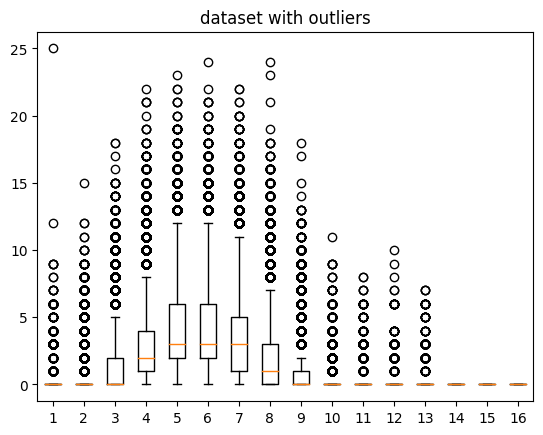

In [11]:
_ = plt.title("dataset with outliers")
_ = plt.boxplot(df.values, showfliers=True)

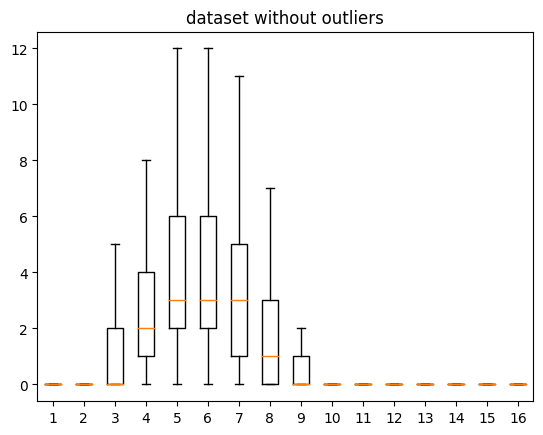

In [12]:
_ = plt.title("dataset without outliers")
_ = plt.boxplot(df.values, showfliers=False)

You should see all integers if you are using the `dataset 6-7-8` with 14th column quantized

In [13]:
pd.DataFrame(X_test[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,1,3,3,5,3,3,0,0,0,0,0,0,0,0
1,0,0,0,4,9,6,7,3,0,0,0,0,0,0,0,0
2,0,0,2,3,4,3,1,0,0,0,0,0,0,0,0,0
3,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0
4,0,0,5,6,5,5,2,0,0,0,0,0,0,0,0,0
5,0,3,4,5,4,4,6,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,3,4,3,3,0,0,0,0,0,0,0
7,0,0,0,0,0,9,8,9,4,0,0,0,0,0,0,0
8,0,1,5,5,6,7,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,3,8,8,8,0,0,0,0,0,0,0,0


In [14]:
pd.DataFrame(y_test[:10])

,0
0,2
1,0
2,1
3,0
4,1
5,2
6,0
7,1
8,0
9,1


In [15]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 25 , log2(max)= 5 , min= 0
X_test: max= 21 , log2(max)= 5 , min= 0


### Scale dataset

<p style="background-color:Yellow;"><b>Disabling scaling will simplify the hardware design</b></p>

In [16]:
scale = False

In [17]:
scaling = ''
if scale:
    scaling = 'scaling_'
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
else:
    scaling = 'noscaling_'

#### Visualize dataset post-scaling

In [18]:
pd.DataFrame(X_train).to_csv('csv/' + dataset + scaling + 'InputTrainSetScale.csv',index=False)
pd.DataFrame(X_test).to_csv('csv/' + dataset + scaling + 'InputTestSetScale.csv',index=False)

In [19]:
pd.DataFrame(X_test[:10])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,1,3,3,5,3,3,0,0,0,0,0,0,0,0
1,0,0,0,4,9,6,7,3,0,0,0,0,0,0,0,0
2,0,0,2,3,4,3,1,0,0,0,0,0,0,0,0,0
3,0,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0
4,0,0,5,6,5,5,2,0,0,0,0,0,0,0,0,0
5,0,3,4,5,4,4,6,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,3,4,3,3,0,0,0,0,0,0,0
7,0,0,0,0,0,9,8,9,4,0,0,0,0,0,0,0
8,0,1,5,5,6,7,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,3,8,8,8,0,0,0,0,0,0,0,0


In [20]:
import math
max_value_X_train = np.max(X_train)
min_value_X_train = np.min(X_train)
max_value_X_test = np.max(X_test)
min_value_X_test = np.min(X_test)

log2_max_value_X_train = int(np.ceil(math.log2(np.abs(max_value_X_train))))
#log2_min_value_X_train = int(np.ceil(math.log2(np.abs(min_value_X_train))))
log2_max_value_X_test = int(np.ceil(math.log2(np.abs(max_value_X_test))))
#log2_min_value_X_test = int(np.ceil(math.log2(np.abs(min_value_X_test))))

print('X_train: max=', max_value_X_train, ', log2(max)=', log2_max_value_X_train, ', min=', min_value_X_train)
print('X_test: max=', max_value_X_test, ', log2(max)=', log2_max_value_X_test, ', min=', min_value_X_test)

X_train: max= 25 , log2(max)= 5 , min= 0
X_test: max= 21 , log2(max)= 5 , min= 0


### One-hot encoding

In [21]:
y_train_oh = pd.get_dummies(df2['ptLabel'])
y_test_oh = pd.get_dummies(df4['ptLabel'])

y_train_oh.to_csv("csv/" + dataset + "labelsTrainOH.csv",index=False)
y_test_oh.to_csv("csv/" + dataset + "labelsTestOH.csv",index=False)

In [22]:
display_side_by_side(pd.DataFrame(y_test[:10]), pd.DataFrame(y_test_oh[:10]), titles=['Prediction','One-hot encoding'])

,0
0,2
1,0
2,1
3,0
4,1
5,2
6,0
7,1
8,0
9,1


### Save .dat files

In [23]:
!mkdir -p csv/pad/l$local_id
pd.DataFrame(X_test).to_csv('csv/pad/l{:d}/tb_input_features.dat'.format(local_id), sep=' ', index=False)
y_test_oh.to_csv('csv/pad/l{:d}/tb_output_predictions.dat'.format(local_id), sep=' ', index=False)

## Model (Keras)

Let's start with a Keras model that is more traditional and uses floating-point. Our goal is to eventually get a quantized model for QKeras and hls4ml that is _close enough_ to this initial model.

### Model definition

Define a few MLP models with different size and number of layers

In [24]:
models = {}

#### d128

This is our original model that we also use as a reference

In [25]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(128, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d128'] = {
    'prefix': dataset + padding + scaling + 'keras_d128',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d64

In [26]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(64, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d64'] = {
    'prefix': dataset + padding + scaling + 'keras_d64',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d60

In [27]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(60, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d60'] = {
    'prefix': dataset + padding + scaling + 'keras_d60',
    'type'  : 'keras',
    'def'   : CreateModel}

#### d58

In [28]:
def CreateModel(shape, nb_classes):
    x = x_in = Input(shape, name="input")
    x = Dense(58, name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = Activation("relu", name="relu1")(x)
    x = Dense(3, name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

models['d58'] = {
    'prefix': dataset + padding + scaling + 'keras_d58',
    'type'  : 'keras',
    'def'   : CreateModel}

### Model create and summary

Show the dictionary of models

In [29]:
print_dictionary(models)

d128
  prefix
    ds8l0_padded_noscaling_keras_d128
  type
    keras
  def
    <function CreateModel at 0x14b7438c9820>
d64
  prefix
    ds8l0_padded_noscaling_keras_d64
  type
    keras
  def
    <function CreateModel at 0x14b7438c9af0>
d60
  prefix
    ds8l0_padded_noscaling_keras_d60
  type
    keras
  def
    <function CreateModel at 0x14b7438c9ee0>
d58
  prefix
    ds8l0_padded_noscaling_keras_d58
  type
    keras
  def
    <function CreateModel at 0x14b7438d0310>


<p style="background-color:Yellow;"><b>Choose a model for training and testing</b></p>


In [30]:
#chosen_model = 'd64' # <<< PAY ATTENTION <<<
#chosen_model = 'd60' # <<< PAY ATTENTION <<<
chosen_model = 'd58' # <<< PAY ATTENTION <<<

In [31]:
model_prefix = models[chosen_model]['prefix']
model_def = models[chosen_model]['def']
model_type = models[chosen_model]['type']

In [32]:
print(model_prefix)

ds8l0_padded_noscaling_keras_d58


In [33]:
print(y_train)

[[0]
 [0]
 [0]
 ...
 [1]
 [2]
 [1]]


In [34]:
model = model_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16)]              0         
                                                                 
 dense1 (Dense)              (None, 58)                986       
                                                                 
 batch_normalization (BatchN  (None, 58)               232       
 ormalization)                                                   
                                                                 
 relu1 (Activation)          (None, 58)                0         
                                                                 
 dense2 (Dense)              (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                             

### Model training

In [35]:
train_and_save = True # <<< PAY ATTENTION <<<

In [36]:
model_file = 'models/' + model_prefix + 'model.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=512,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

### Model evaluation

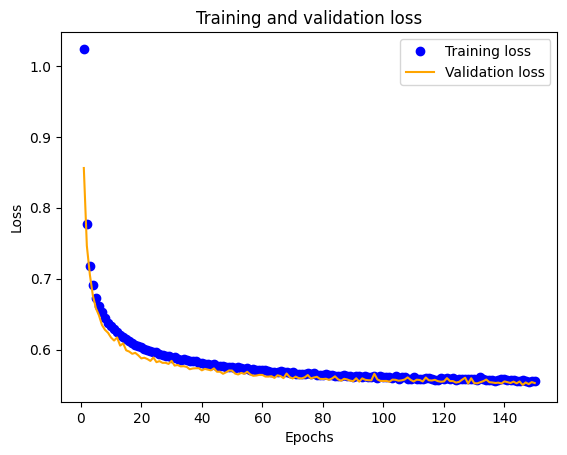

In [37]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + model_prefix + '_loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + model_prefix + '_loss.png')
    display(img)

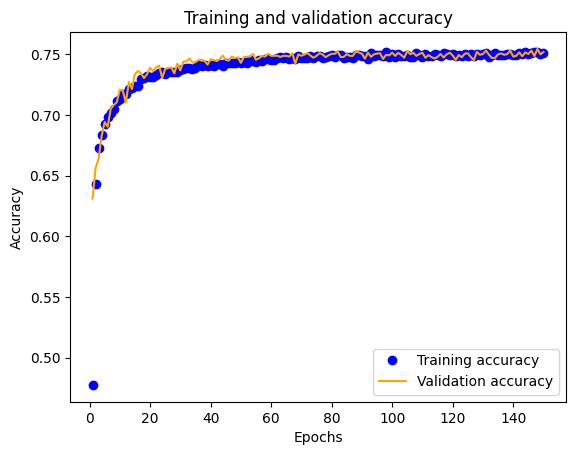

In [38]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + model_prefix + '_accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + model_prefix + '_accuracy.png')
    display(img)

In [39]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

348/348 [==============================] - 0s 724us/step


In [40]:
pd.DataFrame(predictionsFiles).to_csv('csv/' + model_prefix + '_predictionsFiles.csv', header='predict', index=False)

In [41]:
pd.DataFrame(y_test).to_csv('csv/' + model_prefix + '_true.csv', header='true', index=False)
print('csv/' + model_prefix + '_true.csv')

csv/ds8l0_padded_noscaling_keras_d58_true.csv


In [42]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (Keras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (Keras) {}: {}".format(chosen_model, score[1]))

Test loss (Keras) d58: 0.5666695237159729
Test accuracy (Keras) d58: 0.7445334196090698


Confusion matrix:
[[4843  639  561]
 [ 858 1860   18]
 [ 760    3 1571]]


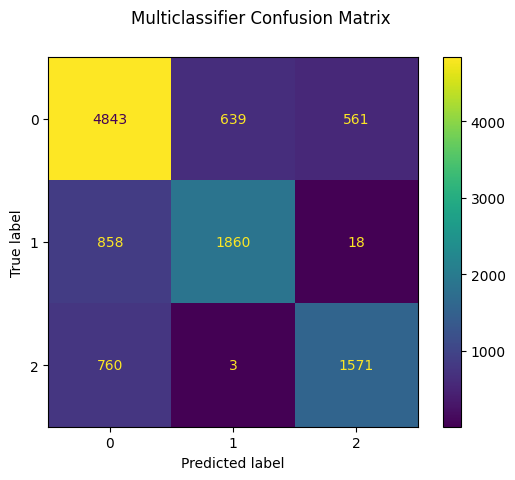

In [43]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + model_prefix + '_confusionMatrix.png')
plt.show()

Besides ML accuracy, we can evaluate the model with a metric that is closer to the physical application. We use _the number of tracks that are greater of 1.0 GeV and that are correctly classified as high pT_.

In [44]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + model_type + '_' + chosen_model, pt_data)

In [45]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0, '<<<')
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.8014231342048651
- 0.5GeV correctly classified as high pT: 0.8861386138613861
- 1.0GeV correctly classified as high pT: 0.9180588703261734
- 2.0GeV correctly classified as high pT: 0.9458128078817734 <<<
---


In [46]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + model_type + '_' + chosen_model, pt_data)

Summary of the results.

The model **id** is a label of the kind `dataset_scale_mltype_mlmodel`:
- `dataset` can be `ds7` (the original dataset) or `ds678` (the larger dataset with quantized 14th column)
- `scale` can be `scaling` (use standard scaler) or `noscaling` (don't scale)
- `mltype` can be `keras` (Keras), `qkeras` (QKeras), and `qkeras_foldbatchnorm` (QKeras + patch to fold batch normalization layer in the previous dense layer)
- `mlmodel` can be `d128`, `d64`, etc.

In [47]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,ds8l0_padded_noscaling_keras_d58,0.5667,0.7445,0.8014,0.8861,0.9181,0.9458,0.4254


Current and previous results

In [48]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, model_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [49]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,06/07/2023 15:49:40,ds8l0_padded_noscaling_keras_d58,0.5674,0.7447,0.7979,0.8858,0.9181,0.9409,0.4290
1,06/07/2023 15:50:03,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5923,0.7325,0.8039,0.8809,0.9077,0.9261,0.4097
2,06/07/2023 15:50:20,ds8l0_padded_noscaling_hls4ml_qkeras_foldbatch...,0.0000,0.7313,0.8019,0.8806,0.9093,0.9261,0.4107
3,06/07/2023 15:50:56,ds8l1_padded_noscaling_keras_d58,0.5627,0.7370,0.8060,0.8856,0.8975,0.9346,0.4276
4,06/07/2023 15:51:18,ds8l1_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5968,0.7218,0.7613,0.8458,0.8659,0.8972,0.4582
...,...,...,...,...,...,...,...,...,...
357,06/07/2023 18:37:42,ds8l11_padded_noscaling_keras_d58,0.7957,0.6254,0.8527,0.8711,0.8634,0.8633,0.2607
358,06/07/2023 18:38:18,ds8l11_padded_noscaling_qkeras_foldbatchnorm_d...,0.8558,0.5943,0.9079,0.9226,0.9229,0.9029,0.1688
359,06/07/2023 18:38:35,ds8l11_padded_noscaling_hls4ml_qkeras_foldbatc...,0.0000,0.5939,0.9016,0.9173,0.9202,0.8993,0.1759
360,01/08/2023 15:19:22,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5927,0.7282,0.7968,0.8762,0.9014,0.9212,0.4133


Average results so far

In [50]:
print_avg_results(results_filename)

,accuracy,nt_gev20,count
id,,,
ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.7299,0.9320,10
ds8l0_padded_noscaling_keras_d58,0.7456,0.9481,11
ds8l0_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.7296,0.9315,11
ds8l10_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.6396,0.8132,10
ds8l10_padded_noscaling_keras_d58,0.6892,0.8766,10
ds8l10_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.6396,0.8060,10
ds8l11_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.5781,0.8766,10
ds8l11_padded_noscaling_keras_d58,0.6281,0.8748,10
ds8l11_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5779,0.8723,10


In [51]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    #'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    #'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )
print(id_ordering)
print(results_filename)

['ds8l11_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l10_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l9_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l8_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l7_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l6_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l5_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l4_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l3_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l2_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l1_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8']
csv/results.csv


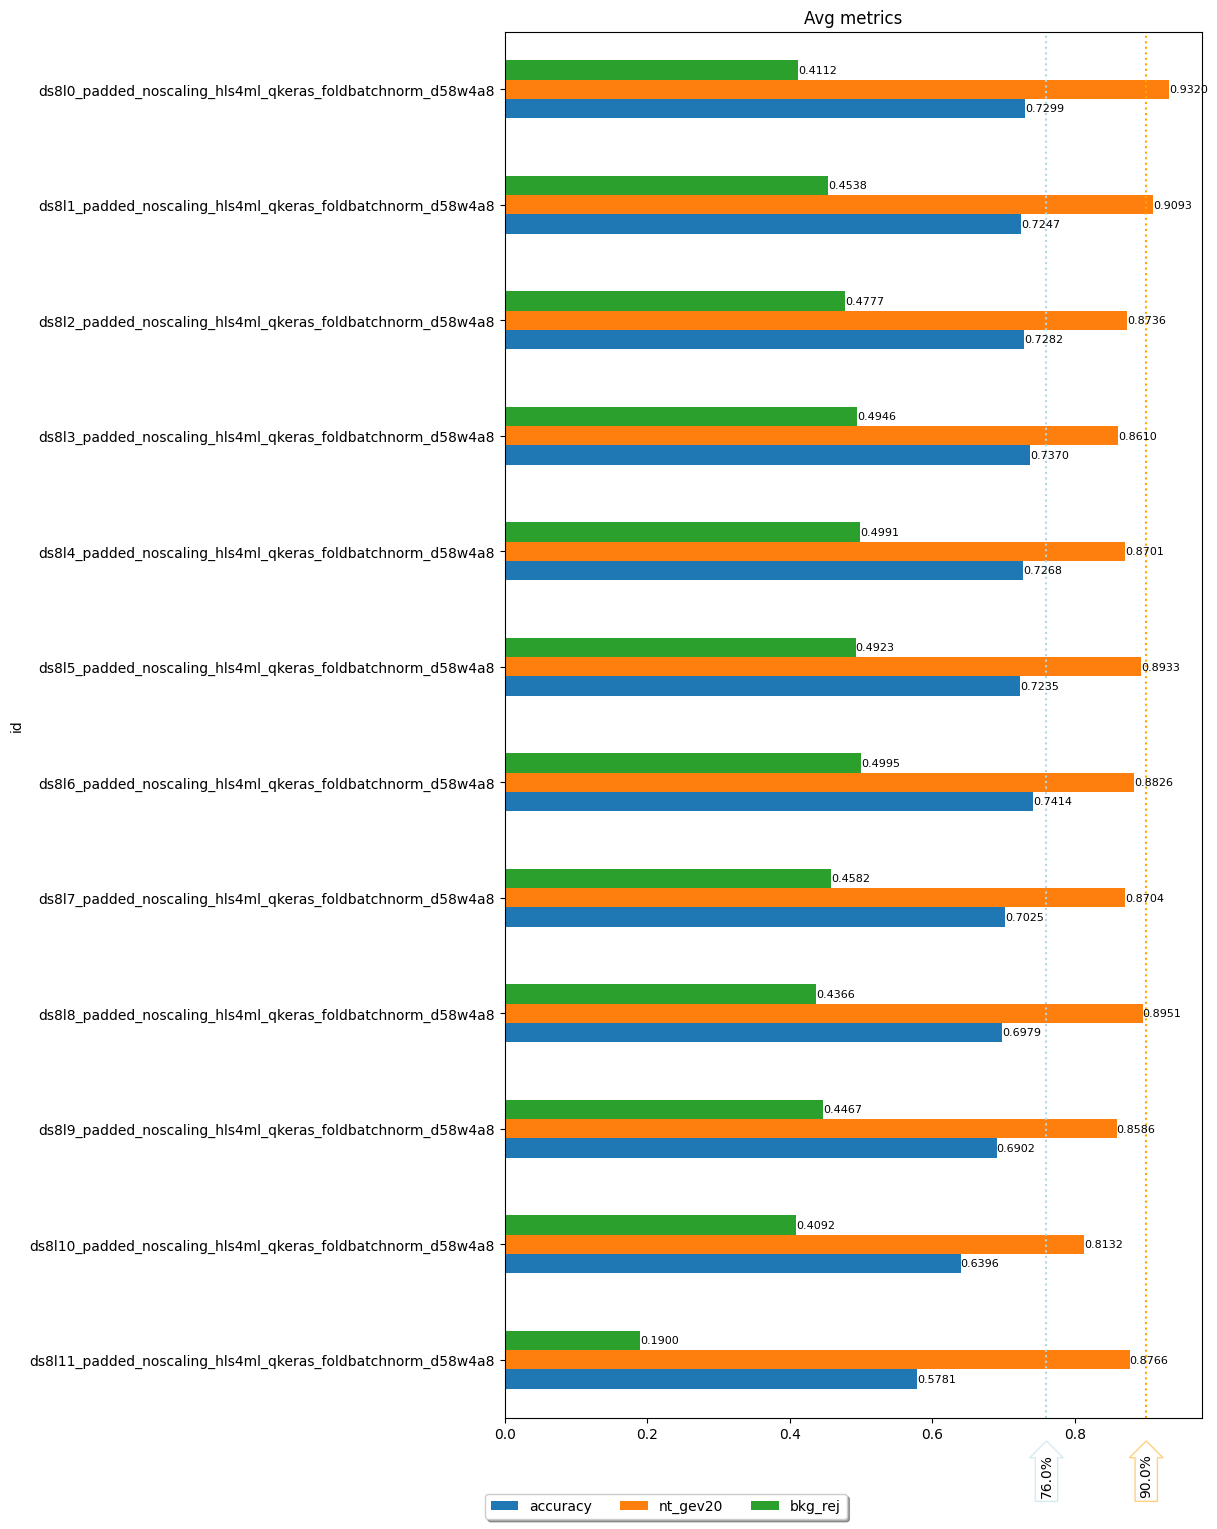

In [52]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

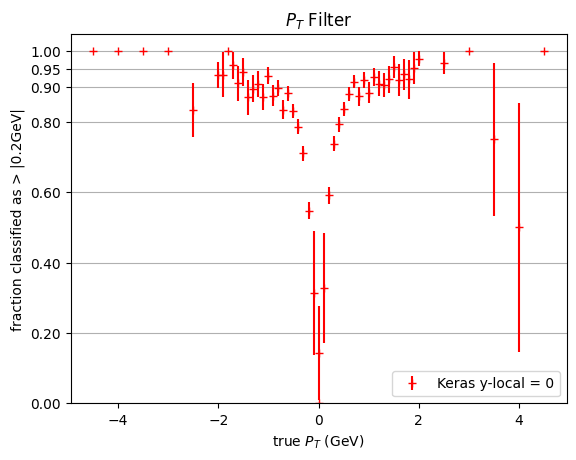

In [53]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q=None, predict_data_q=None, true_data_q=None,
               label_h=None, predict_data_h=None, true_data_h=None,
               output_image='images/' + model_prefix + '_turnonCurve.png',
               base_dir='.')

## Model (QKeras)

Mostly the same as the previous section, but now we are usin QKeras

### Model definition

In [54]:
qmodels = {}

#### qkeras-foldbatchnorm-d128w5a10

In [55]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d128w4a8

In [56]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d128w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d128w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w5a10

In [57]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d64w4a8

In [58]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(64,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d64w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d64w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w5a10

In [59]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d60w4a8

In [60]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(60,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d60w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d60w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w5a10

In [61]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    x = QDenseBatchnorm(58,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1),
        bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w5a10'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w5a10',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

#### qkeras-foldbatchnorm-d58w4a8

In [62]:
# Fold BatchNormalization in QDense
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape, name="input1")
    
    x = QDenseBatchnorm(58,
      kernel_quantizer=quantized_bits(4,0,alpha=1),
      bias_quantizer=quantized_bits(4,0,alpha=1),
      name="dense1")(x)
    # x = QDense(58,
    #      kernel_quantizer=quantized_bits(4,0,alpha=1),
    #      bias_quantizer=quantized_bits(4,0,alpha=1),
    #      name="dense1")(x)
    # x = keras.layers.BatchNormalization()(x)
    
    x = QActivation("quantized_relu(8,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(4,0,alpha=1),
        bias_quantizer=quantized_bits(4,0,alpha=1),
        name="dense2")(x)
    x = Activation("linear", name="linear")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

qmodels['d58w4a8'] = {
    'prefix': dataset + padding + scaling + 'qkeras_foldbatchnorm_d58w4a8',
    'type'  : 'qkeras_foldbatchnorm',
    'def'   : CreateQModel}

### Model create and summary

In [63]:
print_dictionary(qmodels)

d128w5a10
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d128w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e27dc0>
d128w4a8
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d128w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e27f70>
d64w5a10
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d64w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e394c0>
d64w4a8
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d64w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e39820>
d60w5a10
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d60w5a10
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e39b80>
d60w4a8
  prefix
    ds8l0_padded_noscaling_qkeras_foldbatchnorm_d60w4a8
  type
    qkeras_foldbatchnorm
  def
    <function CreateQModel at 0x14b2f9e39ee0>
d58w5a10
  prefix
    ds8l0_padded_noscaling_qke

<p style="background-color:Yellow;"><b>Choose a QKeras model for training and testing. Pay attention to the previously created model in Keras.</b></p>

In [64]:
print('Keras model:', chosen_model)

Keras model: d58


In [65]:
#chosen_qmodel = 'd64w5a10'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd64w4a8'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd60w5a10'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd60w4a8'  # <<< PAY ATTENTION <<<
#chosen_qmodel = 'd58w5a10'  # <<< PAY ATTENTION <<<
chosen_qmodel = 'd58w4a8'  # <<< PAY ATTENTION <<<

In [66]:
qmodel_prefix = qmodels[chosen_qmodel]['prefix']
qmodel_def = qmodels[chosen_qmodel]['def']
qmodel_type = qmodels[chosen_qmodel]['type']

In [67]:
model = qmodel_def(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input1 (InputLayer)         [(None, 16)]              0         
                                                                 
 dense1 (QDenseBatchnorm)    (None, 58)                1219      
                                                                 
 relu1 (QActivation)         (None, 58)                0         
                                                                 
 dense2 (QDense)             (None, 3)                 177       
                                                                 
 linear (Activation)         (None, 3)                 0         
                                                                 
Total params: 1,396
Trainable params: 1,279
Non-trainable params: 117
_________________________________________________________________


### Model training

In [68]:
train_and_save = True # <<< PAY ATTENTION <<<

In [69]:
from qkeras.utils import model_save_quantized_weights

model_file = 'models/' + qmodel_prefix + 'model.h5'
model_q_weights_file = 'models/' + qmodel_prefix + 'model_q_weights.h5'

history = None
if train_and_save:
    es = EarlyStopping(monitor='val_loss',
                       #monitor='val_sparse_categorical_accuracy', 
                       #mode='max', # don't minimize the accuracy!
                       patience=20,
                       restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model_save_quantized_weights(model, model_q_weights_file)
    model.save(model_file)
    print('Save:', model_file)
    print('Save:', model_q_weights_file)

co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

... quantizing model
dense1  conv and batchnorm weights cannot be seperately quantized because they will be folded before quantization.
Save: models/ds8l0_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model.h5
Save: models/ds8l0_padded_noscaling_qkeras_foldbatchnorm_d58w4a8model_q_weights.h5


### Model evaluation

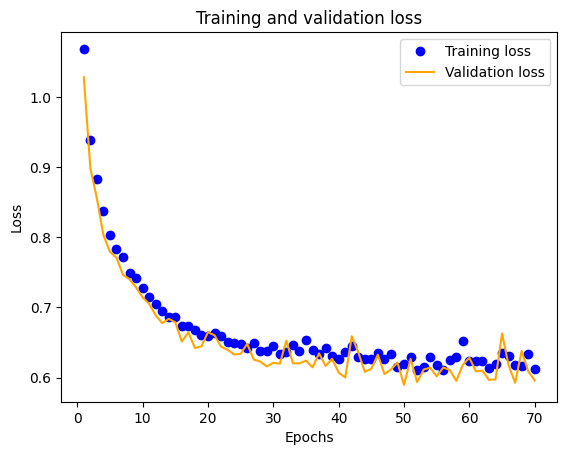

In [70]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + qmodel_prefix + '_loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + qmodel_prefix + '_loss.png')
    display(img)

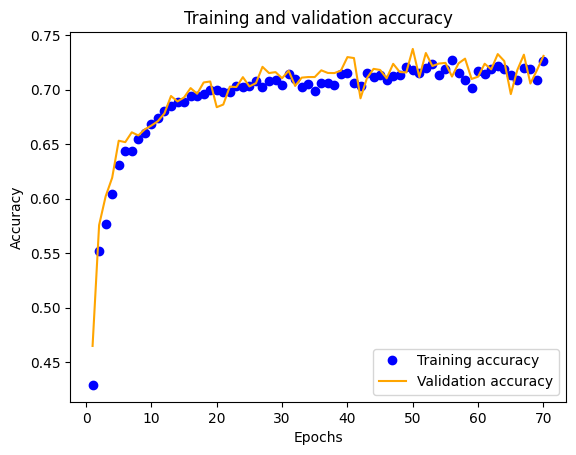

In [71]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + qmodel_prefix + '_accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + qmodel_prefix + '_accuracy.png')
    display(img)

In [72]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

348/348 [==============================] - 0s 938us/step


In [73]:
pd.DataFrame(predictionsFiles).to_csv("csv/" + qmodel_prefix + "_predictionsFiles.csv", header='predict', index=False)

In [74]:
pd.DataFrame(y_test).to_csv("csv/" + qmodel_prefix + "_true.csv", header='true', index=False)

In [75]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss (QKeras) {}: {}".format(chosen_model, score[0]))
print("Test accuracy (QKeras) {}: {}".format(chosen_model, score[1]))

Test loss (QKeras) d58: 0.6084322333335876
Test accuracy (QKeras) d58: 0.7240169048309326


Confusion matrix:
[[4848  636  559]
 [ 935 1782   19]
 [ 912    6 1416]]


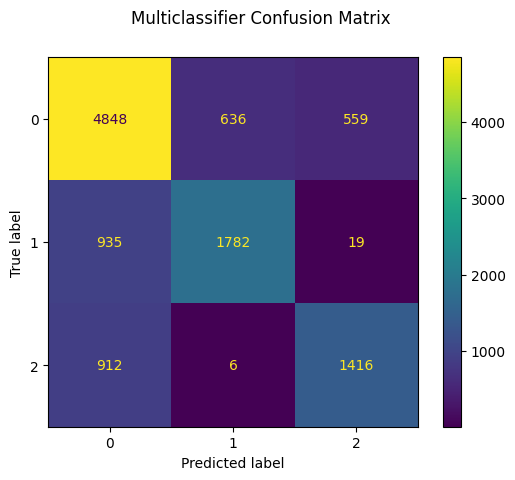

In [76]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + qmodel_prefix + '_confusionMatrix.png')
plt.show()

In [77]:
GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + qmodel_type + '_' + chosen_qmodel, pt_data)

In [78]:
print('---')
print('Number of tracks greater than')
print('- 0.2GeV correctly classified as high pT:', GeV_0_2)
print('- 0.5GeV correctly classified as high pT:', GeV_0_5)
print('- 1.0GeV correctly classified as high pT:', GeV_1_0)
print('- 2.0GeV correctly classified as high pT:', GeV_2_0, '<<<')
print('---')

---
Number of tracks greater than
- 0.2GeV correctly classified as high pT: 0.8022505378123449
- 0.5GeV correctly classified as high pT: 0.877693651718113
- 1.0GeV correctly classified as high pT: 0.9077167859984089
- 2.0GeV correctly classified as high pT: 0.9359605911330049 <<<
---


In [79]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + qmodel_type + '_' + chosen_qmodel, pt_data)

In [80]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.6084,0.7240,0.8023,0.8777,0.9077,0.9360,0.4038


In [81]:
results_filename = 'csv/results.csv'
if train_and_save:
    write_results(results_filename, qmodel_prefix, score[0], score[1], GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [82]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,06/07/2023 15:49:40,ds8l0_padded_noscaling_keras_d58,0.5674,0.7447,0.7979,0.8858,0.9181,0.9409,0.4290
1,06/07/2023 15:50:03,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5923,0.7325,0.8039,0.8809,0.9077,0.9261,0.4097
2,06/07/2023 15:50:20,ds8l0_padded_noscaling_hls4ml_qkeras_foldbatch...,0.0000,0.7313,0.8019,0.8806,0.9093,0.9261,0.4107
3,06/07/2023 15:50:56,ds8l1_padded_noscaling_keras_d58,0.5627,0.7370,0.8060,0.8856,0.8975,0.9346,0.4276
4,06/07/2023 15:51:18,ds8l1_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5968,0.7218,0.7613,0.8458,0.8659,0.8972,0.4582
...,...,...,...,...,...,...,...,...,...
358,06/07/2023 18:38:18,ds8l11_padded_noscaling_qkeras_foldbatchnorm_d...,0.8558,0.5943,0.9079,0.9226,0.9229,0.9029,0.1688
359,06/07/2023 18:38:35,ds8l11_padded_noscaling_hls4ml_qkeras_foldbatc...,0.0000,0.5939,0.9016,0.9173,0.9202,0.8993,0.1759
360,01/08/2023 15:19:22,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5927,0.7282,0.7968,0.8762,0.9014,0.9212,0.4133
361,01/08/2023 15:20:22,ds8l0_padded_noscaling_keras_d58,0.5667,0.7445,0.8014,0.8861,0.9181,0.9458,0.4254


In [83]:
print_avg_results(results_filename)

,accuracy,nt_gev20,count
id,,,
ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.7299,0.9320,10
ds8l0_padded_noscaling_keras_d58,0.7456,0.9481,11
ds8l0_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.7292,0.9319,12
ds8l10_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.6396,0.8132,10
ds8l10_padded_noscaling_keras_d58,0.6892,0.8766,10
ds8l10_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.6396,0.8060,10
ds8l11_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8,0.5781,0.8766,10
ds8l11_padded_noscaling_keras_d58,0.6281,0.8748,10
ds8l11_padded_noscaling_qkeras_foldbatchnorm_d58w4a8,0.5779,0.8723,10


In [84]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )

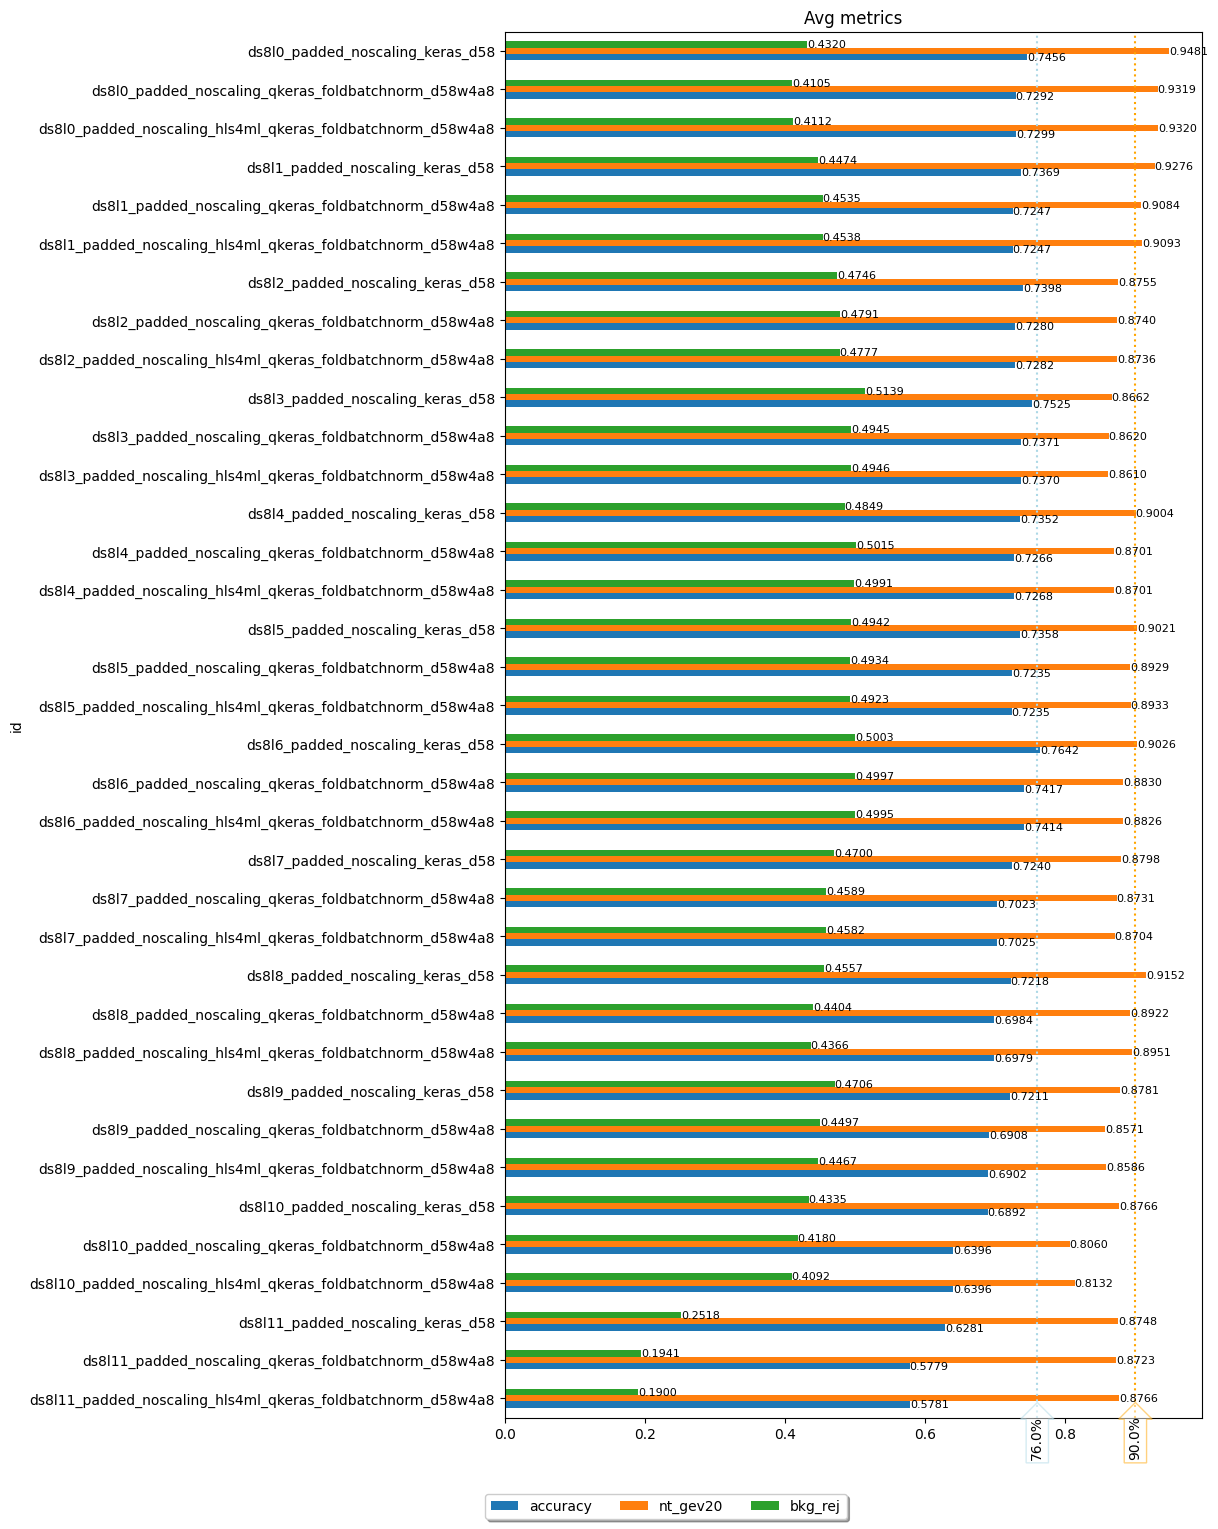

In [85]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

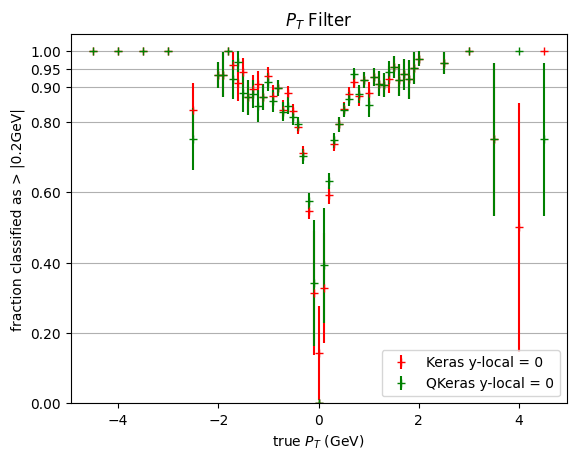

In [86]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q='QKeras y-local = {}'.format(local_id), predict_data_q='csv/' + qmodel_prefix + '_predictionsFiles.csv', true_data_q='csv/' + qmodel_prefix + '_true.csv',
               label_h=None, predict_data_h=None, true_data_h=None,
               output_image='images/' + model_prefix + '_turnonCurve.png',
               base_dir='.')

## Hardware translation

### hls4ml configuration

#### Setup

In [87]:
import hls4ml
import plotting

hmodel_prefix = dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel

In [88]:
print('------------------------------------')
print(hmodel_prefix)
print('------------------------------------')

------------------------------------
ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8
------------------------------------


In [89]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.6.0.dev222+g4a56d6e2.d20230518


In [90]:
import os
os.environ['PATH'] = '/fpga/cad/xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


In [91]:
import os

print('-----------------------------------')
if os.environ.get('MGC_HOME') is not None and is_tool('catapult'):
    print('Siemens Catapult HLS is configured')
else:
    print('Siemens Catapult HLS is NOT configured')
print('-----------------------------------')

-----------------------------------
Siemens Catapult HLS is configured
-----------------------------------


In [93]:
input_size = 6

In [102]:
# hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
     layers=['Activation'],
     rounding_mode='AP_RND_CONV',
     saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

# programmable weights (weights on the interface)
hconfig["Model"]["BramFactor"] = 0

# set bitwidth of the input features
hconfig['LayerName']['input1']['Precision']['result'] = 'ufixed<' + str(input_size) + ',' + str(input_size) + '>'

# enable tracing
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True

# #1
# hconfig['Model']['Precision'] = 'ap_fixed<16,8>'    

# # 2
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<12,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<12,6>'

# # 3
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'

# # 4
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'

# # 5
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,6>'

# # 6
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,5>'

# # 7
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<9,5>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<9,5>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<9,5>'

# # 8
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 9
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<10,5>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 10
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<9,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# # 11
# hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<8,6>'
# hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
# hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# 12
hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense1_linear']['Precision']['result'] = 'ap_fixed<9,6>'
hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<10,4>'
hconfig['LayerName']['dense2_linear']['Precision']['result'] = 'ap_fixed<10,4>'

# Dense
#hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<8,5>'
#hconfig['LayerName']['dense1']['Precision']['default'] = 'ap_fixed<8,5>'
# ReLU
#hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<8,0,AC_RND_CONV,AC_SAT>'
# Dense
#hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<10,6>'
# SoftMax
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'
#hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
#hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
#hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<16,6>'
# Required for the folding of BatchNormalization
#hconfig['SkipOptimizers'] = ['propagate_dense_precision']    
#hconfig['LayerName']['dense1_linear']['Trace'] = True
#hconfig['LayerName']['dense2_linear']['Trace'] = True

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]


#### Convert

In [103]:
plotting.print_dict(hconfig)

Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        0
  TraceOutput:       False
LayerName
  input1
    Trace:           True
    Precision
      result:        ufixed<6,6>
  dense1
    Trace:           True
    Precision
      result:        ap_fixed<9,6>
      weight:        fixed<4,1>
      bias:          fixed<4,1>
    accum_t:         ap_fixed<9,6>
  dense1_linear
    Trace:           True
    Precision
      result:        ap_fixed<9,6>
  relu1
    Trace:           True
    Precision
      result:        ufixed<8,0>
  dense2
    Trace:           True
    Precision
      result:        ap_fixed<10,4>
      weight:        fixed<4,1>
      bias:          fixed<4,1>
    accum_t:         ap_fixed<10,4>
  dense2_linear
    Trace:           True
    Precision
      result:        ap_fixed<10,4>
  linear
    Trace:           True
    Precision
      result:        fixed<16,6>


In [104]:
!rm -rf $hmodel_prefix\_$run_id\_catapult_prj*

In [105]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=hmodel_prefix + '_' + str(run_id) + '_catapult_prj',
                                                    backend='Catapult',
                                                    #output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    #backend='Vivado',
                                                    part='XC7A100T')

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model


In [106]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file='model.png')

### Bit-accurate simulation

In [107]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test.astype(float)))

Recompiling myproject with tracing
Writing HLS project
Done


In [108]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

Processing input1 in Keras model...
Processing dense1 in Keras model...
348/348 [==============================] - 0s 729us/step
Processing relu1 in Keras model...
348/348 [==============================] - 0s 891us/step
Processing dense2 in Keras model...
348/348 [==============================] - 0s 911us/step
Processing linear in Keras model...
348/348 [==============================] - 0s 922us/step
Done taking outputs for Keras model.


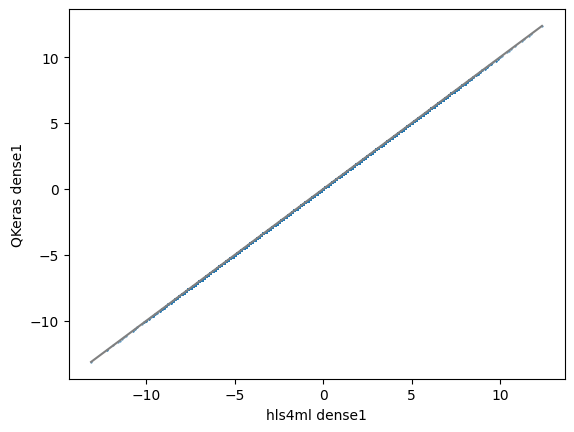

<Figure size 640x480 with 0 Axes>

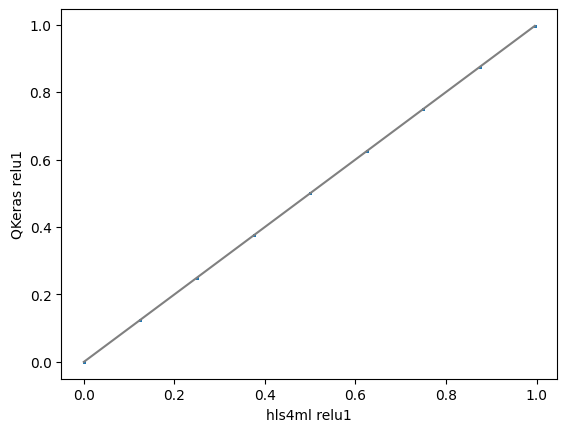

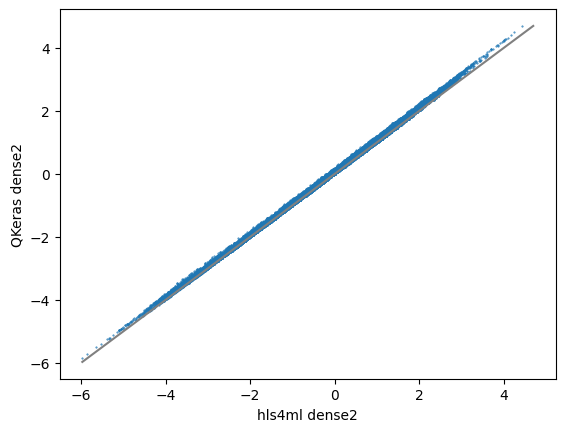

<Figure size 640x480 with 0 Axes>

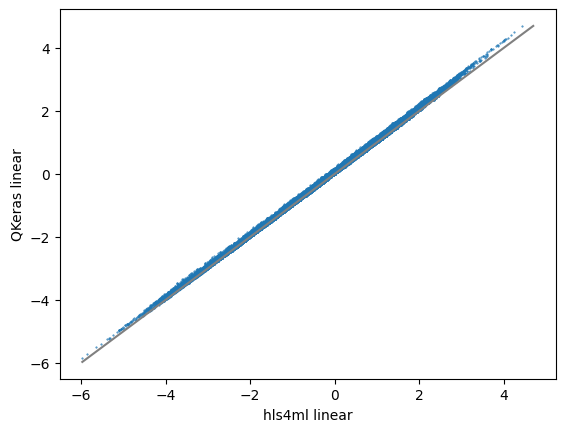

In [109]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    if 'dense1_linear' in layer:
        continue
    if 'dense2_linear' in layer:
        continue
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join(hmodel_prefix + '_' + str(run_id) + '_catapult_prj', 'profiling_{}.png'.format(layer)), dpi=300)

### Model evaluation

In [110]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    clock_period=10.0,
                                                    hls_config=hconfig,
                                                    output_dir=hmodel_prefix + '_' + str(run_id) + '_catapult_prj',
                                                    backend='Catapult',
                                                    #output_dir=hmodel_prefix + '_' + str(run_id) + '_vivado_prj',
                                                    #backend='Vivado',
                                                    part='XC7A100T')

hmodel.compile()

Interpreting Model
Topology:
Layer name: input1, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 16]], output shape: [None, 58]
Layer name: relu1, layer type: Activation, input shapes: [[None, 58]], output shape: [None, 58]
Layer name: dense2, layer type: QDense, input shapes: [[None, 58]], output shape: [None, 3]
Layer name: linear, layer type: Activation, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Writing HLS project
Done


In [111]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test.astype(float)))
np.savetxt('tb_output_predictions_hw.dat', hpreds, fmt='%f')

predictionsFiles = np.argmax(hpreds, axis=1)
pd.DataFrame(predictionsFiles).to_csv("csv/" + hmodel_prefix + "_predictionsFiles.csv", header='predict', index=False)
pd.DataFrame(y_test).to_csv('csv/' + hmodel_prefix + '_true.csv', header='true', index=False)

In [112]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {:.4f}%".format(100*accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')

-----------------------------------
QKeras accuracy: 72.4017%
hls4ml accuracy: 72.3477%
-----------------------------------


In [113]:
hls4ml_accuracy = accuracy_score(np.argmax(y_test_oh.values, axis=1), np.argmax(hpreds, axis=1))

In [114]:
def get_number_of_tracks(model_label, pt_data, base_dir = '.'):
    import numpy as np
    import pandas as pd
    
    print(base_dir + '/csv/' + model_label + '_true.csv')
    print(base_dir + '/csv/' + model_label + '_predictionsFiles.csv')
    print(base_dir + '/csv/' + model_label + '_concatenatedSample.csv')
    print()
    df1 = pd.read_csv(base_dir + '/csv/' + model_label + '_true.csv')
    headers =  ["true"]
    df1.columns = headers
    df2 = pd.read_csv(base_dir + '/csv/' + model_label + '_predictionsFiles.csv')
    headers =  ["predicted"]
    df2.columns = headers
    df3 = pd.concat([df1,df2],  axis=1, join="inner")
    dfPT = pd.read_csv(pt_data)
    df5 = pd.concat([df1,df2,dfPT],  axis=1, join="inner")
    df5.to_csv(base_dir + '/csv/' + model_label + '_concatenatedSample.csv',index=False)
    
    df6=pd.read_csv(base_dir + '/csv/' + model_label + '_concatenatedSample.csv')
    
    display(df6)
    
    df7 = df6.loc[ (df6['pt'] > 0.2) | (df6['pt'] < -0.2)]
    totalNumberRowsSelected = df7.shape[0] 
    predictedCorrect = df7.loc[ df7['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT = predictedCorrect.shape[0] #first number is number of rows
    newAccuracyMetric = numberCorrectlyPredictedAsHighPT/totalNumberRowsSelected
    
    df8 = df6.loc[ (df6['pt'] > 0.5) | (df6['pt'] < -0.5)]
    totalNumberRowsSelected_halfGeV = df8.shape[0] 
    predictedCorrect_halfGeV = df8.loc[ df8['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_halfGeV = predictedCorrect_halfGeV.shape[0] #first number is number of rows
    newAccuracyMetric_halfGeV = numberCorrectlyPredictedAsHighPT_halfGeV/totalNumberRowsSelected_halfGeV
    
    df9 = df6.loc[ (df6['pt'] > 1) | (df6['pt'] < -1)]
    totalNumberRowsSelected_1GeV = df9.shape[0] 
    predictedCorrect_1GeV = df9.loc[df9['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_1GeV = predictedCorrect_1GeV.shape[0] 
    newAccuracyMetric_1GeV = numberCorrectlyPredictedAsHighPT_1GeV/totalNumberRowsSelected_1GeV

    df10 = df6.loc[ (df6['pt'] > 2) | (df6['pt'] < -2)]
    totalNumberRowsSelected_2GeV = df10.shape[0] 
    predictedCorrect_2GeV = df10.loc[df10['predicted'] == 0]
    numberCorrectlyPredictedAsHighPT_2GeV = predictedCorrect_2GeV.shape[0] 
    newAccuracyMetric_2GeV = numberCorrectlyPredictedAsHighPT_2GeV/totalNumberRowsSelected_2GeV

    return (newAccuracyMetric, newAccuracyMetric_halfGeV, newAccuracyMetric_1GeV, newAccuracyMetric_2GeV)

GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0 = get_number_of_tracks(dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel, pt_data)

./csv/ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8_true.csv
./csv/ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8_predictionsFiles.csv
./csv/ds8l0_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8_concatenatedSample.csv



,true,predicted,pt
0,2,0,0.195180
1,0,0,-0.624555
2,1,0,-0.184880
3,0,0,-0.429696
4,1,0,-0.193294
...,...,...,...
11108,0,0,-1.081340
11109,1,1,-0.194622
11110,1,0,-0.183501
11111,0,0,0.258154


In [115]:
bkg_rej = get_bkg_rej(dataset + padding + scaling + 'hls4ml_' + qmodel_type + '_' + chosen_qmodel, pt_data)

In [116]:
with pd.option_context('display.float_format', '{:0.4f}'.format):
    data = pd.DataFrame([[hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej]], columns=["id", "loss", "accuracy", "nt_gev02", "nt_gev05", "nt_gev10", "nt_gev20", "bkg_rej"])
    display(data)

,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,ds8l0_padded_noscaling_hls4ml_qkeras_foldbatch...,0,0.7235,0.8021,0.8765,0.9077,0.9360,0.4033


In [117]:
results_filename = 'csv/results.csv'
write_results(results_filename, hmodel_prefix, 0, hls4ml_accuracy, GeV_0_2, GeV_0_5, GeV_1_0, GeV_2_0, bkg_rej)

In [118]:
print_results(results_filename)

,date,id,loss,accuracy,nt_gev02,nt_gev05,nt_gev10,nt_gev20,bkg_rej
0,06/07/2023 15:49:40,ds8l0_padded_noscaling_keras_d58,0.5674,0.7447,0.7979,0.8858,0.9181,0.9409,0.4290
1,06/07/2023 15:50:03,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5923,0.7325,0.8039,0.8809,0.9077,0.9261,0.4097
2,06/07/2023 15:50:20,ds8l0_padded_noscaling_hls4ml_qkeras_foldbatch...,0.0000,0.7313,0.8019,0.8806,0.9093,0.9261,0.4107
3,06/07/2023 15:50:56,ds8l1_padded_noscaling_keras_d58,0.5627,0.7370,0.8060,0.8856,0.8975,0.9346,0.4276
4,06/07/2023 15:51:18,ds8l1_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5968,0.7218,0.7613,0.8458,0.8659,0.8972,0.4582
...,...,...,...,...,...,...,...,...,...
359,06/07/2023 18:38:35,ds8l11_padded_noscaling_hls4ml_qkeras_foldbatc...,0.0000,0.5939,0.9016,0.9173,0.9202,0.8993,0.1759
360,01/08/2023 15:19:22,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.5927,0.7282,0.7968,0.8762,0.9014,0.9212,0.4133
361,01/08/2023 15:20:22,ds8l0_padded_noscaling_keras_d58,0.5667,0.7445,0.8014,0.8861,0.9181,0.9458,0.4254
362,01/08/2023 15:20:42,ds8l0_padded_noscaling_qkeras_foldbatchnorm_d5...,0.6084,0.7240,0.8023,0.8777,0.9077,0.9360,0.4038


In [119]:
id_ordering = get_model_ids(lrange=range(12),
                            srange=['padded_noscaling'],
                            mrange=[#'keras_d128',
                                    #'qkeras_foldbatchnorm_d128w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d128w5a10',
                                    #
                                    #'keras_d64',
                                    #'qkeras_foldbatchnorm_d64w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w5a10',
                                    #'qkeras_foldbatchnorm_d64w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d64w4a8',
                                    #
                                    #'keras_d60',
                                    #'qkeras_foldbatchnorm_d60w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w5a10',
                                    #'qkeras_foldbatchnorm_d60w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d60w4a8',
                                    #
                                    'keras_d58',
                                    #'qkeras_foldbatchnorm_d58w5a10',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w5a10',
                                    #'qkeras_foldbatchnorm_d58w4a8',
                                    #'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                    'qkeras_foldbatchnorm_d58w4a8',
                                    'hls4ml_qkeras_foldbatchnorm_d58w4a8',
                                   ],
                            reverse=True
                           )
print(id_ordering)

['ds8l11_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l11_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l11_padded_noscaling_keras_d58', 'ds8l10_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l10_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l10_padded_noscaling_keras_d58', 'ds8l9_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l9_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l9_padded_noscaling_keras_d58', 'ds8l8_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l8_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l8_padded_noscaling_keras_d58', 'ds8l7_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l7_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l7_padded_noscaling_keras_d58', 'ds8l6_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l6_padded_noscaling_qkeras_foldbatchnorm_d58w4a8', 'ds8l6_padded_noscaling_keras_d58', 'ds8l5_padded_noscaling_hls4ml_qkeras_foldbatchnorm_d58w4a8', 'ds8l5_padded

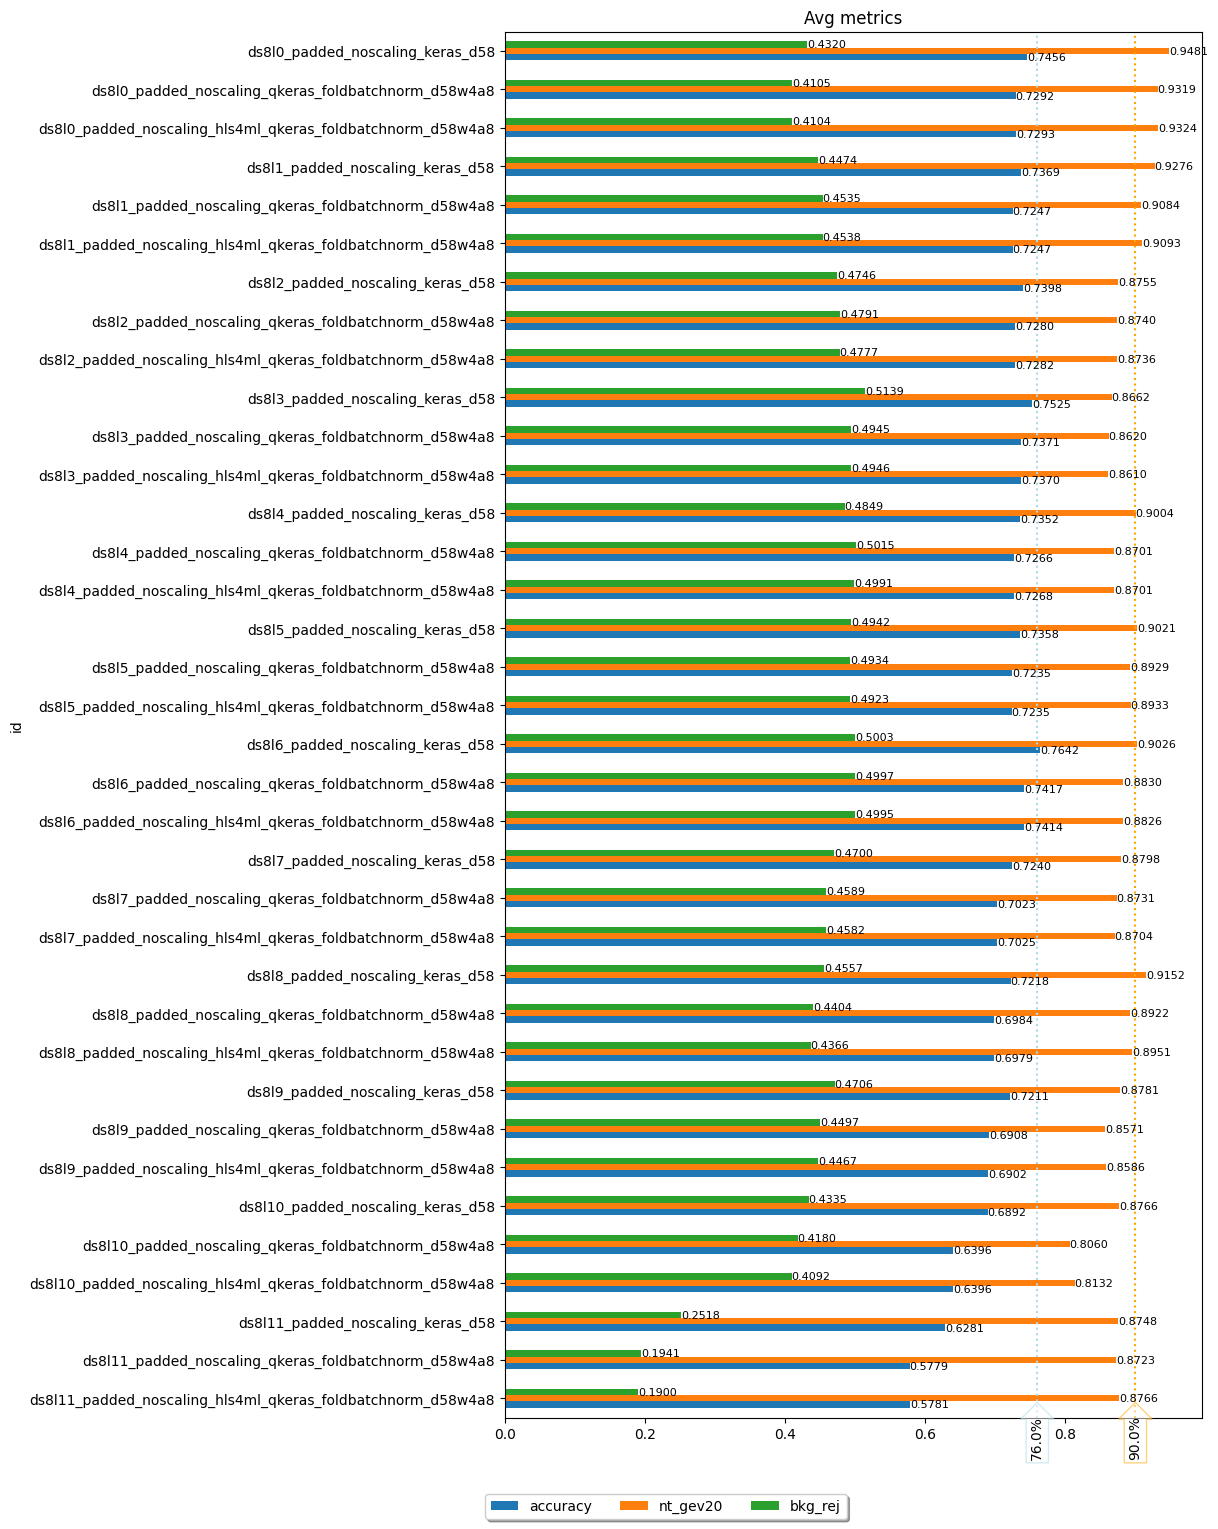

In [120]:
plot_avg_results(results_filename, accuracy_th=0.76, tracks_th=0.9, id_ordering=id_ordering)

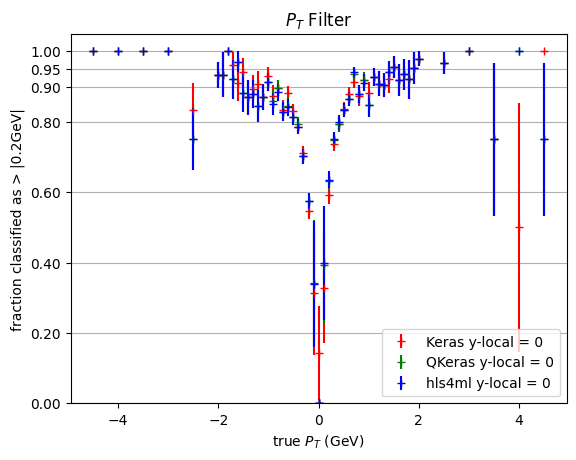

In [121]:
plot_pt_filter(local_id=local_id, 
               pt_data=pt_data,
               label_k='Keras y-local = {}'.format(local_id), predict_data_k='csv/' + model_prefix + '_predictionsFiles.csv', true_data_k='csv/' + model_prefix + '_true.csv',
               label_q='QKeras y-local = {}'.format(local_id), predict_data_q='csv/' + qmodel_prefix + '_predictionsFiles.csv', true_data_q='csv/' + qmodel_prefix + '_true.csv',
               label_h='hls4ml y-local = {}'.format(local_id), predict_data_h='csv/' + hmodel_prefix + '_predictionsFiles.csv', true_data_h='csv/' + hmodel_prefix + '_true.csv',
               output_image='images/' + hmodel_prefix + '_turnonCurve.png',
               base_dir='.')

### Synthesis